<a href="https://colab.research.google.com/github/ariG23498/custom-inference-endpoint/blob/main/flux.2-with-remote-text-encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation and Setup

In [1]:
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers
!pip install --upgrade -qq bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 44.7 MB/s eta 0:00:00


In [2]:
from diffusers import Flux2Pipeline, Flux2Transformer2DModel
from diffusers import BitsAndBytesConfig as DiffBitsAndBytesConfig
from huggingface_hub import get_token
import requests
import torch
import io

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [3]:
import diffusers
import torch

print(f"{torch.__version__=}")
print(f"{diffusers.__version__=}")

torch.__version__='2.9.0+cu126'
diffusers.__version__='0.36.0.dev0'


In [4]:
print(f"Using GPU: {torch.cuda.get_device_name()}")
print(f"Total VRAM: {torch.cuda.get_device_properties().total_memory // 1024**3} GBs")

Using GPU: NVIDIA L4
Total VRAM: 22 GBs


## Run Inference

In [5]:
repo_id = "black-forest-labs/FLUX.2-dev"

quantized_dit_id = "diffusers/FLUX.2-dev-bnb-4bit"
dit = Flux2Transformer2DModel.from_pretrained(
  quantized_dit_id, subfolder="transformer", torch_dtype=torch.bfloat16, device_map="cpu"
)

pipe = Flux2Pipeline.from_pretrained(
  repo_id,
  text_encoder=None,
  transformer=dit,
  torch_dtype=torch.bfloat16,
)
pipe.enable_model_cpu_offload()

config.json:   0%|          | 0.00/993 [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/9.99G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/8.13G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/431 [00:00<?, ?B/s]

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer/tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/2.67k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/770 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/198k [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
def remote_text_encoder(prompts: str | list[str]):
    response = requests.post(
        "https://rhknk53jznw37un7.us-east-1.aws.endpoints.huggingface.cloud/predict",
        json={"prompt": prompts},
        headers={
            "Authorization": f"Bearer {get_token()}",
            "Content-Type": "application/json"
        }
    )
    assert response.status_code == 200, f"{response.status_code=}"
    prompt_embeds = torch.load(io.BytesIO(response.content))
    return prompt_embeds.to("cuda")

print("Running remote text encoder ☁️")
prompt = "a photo of a forest with mist swirling around the tree trunks. The word 'FLUX.2 in diffusers' is painted over it in big, red brush strokes with visible texture"
prompt_embeds = remote_text_encoder([prompt])
print("Done ✅")

Running remote text encoder ☁️
Done ✅


  0%|          | 0/50 [00:00<?, ?it/s]

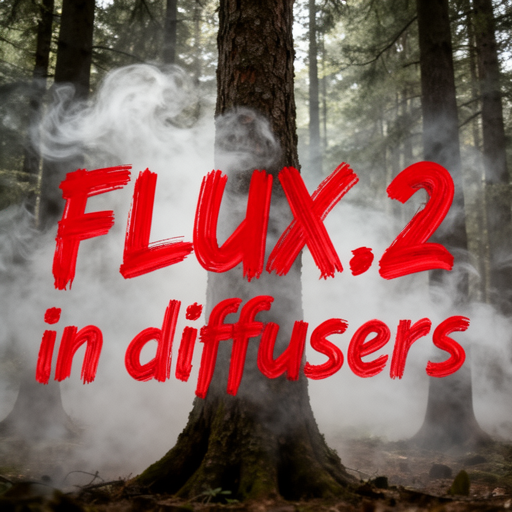

In [7]:
out = pipe(
  prompt_embeds=prompt_embeds,
  generator=torch.Generator(device="cuda").manual_seed(42),
  num_inference_steps=50, # 28 is a good trade-off
  guidance_scale=4,
  height=512,
  width=512,
)

out.images[0]